### Import Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

import privacy.optimizers.dp_optimizer as optimizers
from privacy.analysis.rdp_accountant import compute_rdp
from privacy.analysis.rdp_accountant import get_privacy_spent
from privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer, DPAdamOptimizer
from privacy.dp_query.gaussian_query import GaussianAverageQuery, GaussianSumQuery

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

/Users/Srivatsa/Desktop/Tutorials & Notes/Y4S1/ISM/code/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Srivatsa/Desktop/Tutorials & Notes/Y4S1/ISM/code/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Srivatsa/Desktop/Tutorials & Notes/Y4S1/ISM/code/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.d

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





module `bolt_on` was not found in this version of TF Privacy


### 1. Data exploration

In [2]:
df_full = pd.read_csv('./data/UCI_cervical_cancer.csv')

In [3]:
df_full

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,34,3.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
854,32,2.0,19.0,1.0,0.0,0.0,0.0,1.0,8.0,0.0,...,?,?,0,0,0,0,0,0,0,0
855,25,2.0,17.0,0.0,0.0,0.0,0.0,1.0,0.08,0.0,...,?,?,0,0,0,0,0,0,1,0
856,33,2.0,24.0,2.0,0.0,0.0,0.0,1.0,0.08,0.0,...,?,?,0,0,0,0,0,0,0,0


In [4]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
Age                                   858 non-null int64
Number of sexual partners             858 non-null object
First sexual intercourse              858 non-null object
Num of pregnancies                    858 non-null object
Smokes                                858 non-null object
Smokes (years)                        858 non-null object
Smokes (packs/year)                   858 non-null object
Hormonal Contraceptives               858 non-null object
Hormonal Contraceptives (years)       858 non-null object
IUD                                   858 non-null object
IUD (years)                           858 non-null object
STDs                                  858 non-null object
STDs (number)                         858 non-null object
STDs:condylomatosis                   858 non-null object
STDs:cervical condylomatosis          858 non-null object
STDs:vaginal condylomatosi

In [5]:
df_fullna = df_full.replace('?', np.nan)

In [6]:
df_fullna.isnull().sum() #check NaN counts in different columns

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis B                  

### 2. Data-preprocessing

In [7]:
df = df_fullna  #making temporary save

In [8]:
df = df.apply(pd.to_numeric) #turn data into numeric type for computation

In [9]:
df.info() # Now it's all numeric type, and we are ready for computation and fill NaN.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
Age                                   858 non-null int64
Number of sexual partners             832 non-null float64
First sexual intercourse              851 non-null float64
Num of pregnancies                    802 non-null float64
Smokes                                845 non-null float64
Smokes (years)                        845 non-null float64
Smokes (packs/year)                   845 non-null float64
Hormonal Contraceptives               750 non-null float64
Hormonal Contraceptives (years)       750 non-null float64
IUD                                   741 non-null float64
IUD (years)                           741 non-null float64
STDs                                  753 non-null float64
STDs (number)                         753 non-null float64
STDs:condylomatosis                   753 non-null float64
STDs:cervical condylomatosis          753 non-null float64
STDs:vaginal

In [10]:
# for continuous variable
df['Number of sexual partners'] = df['Number of sexual partners'].fillna(df['Number of sexual partners'].median())
df['First sexual intercourse'] = df['First sexual intercourse'].fillna(df['First sexual intercourse'].median())
df['Num of pregnancies'] = df['Num of pregnancies'].fillna(df['Num of pregnancies'].median())
df['Smokes'] = df['Smokes'].fillna(1)
df['Smokes (years)'] = df['Smokes (years)'].fillna(df['Smokes (years)'].median())
df['Smokes (packs/year)'] = df['Smokes (packs/year)'].fillna(df['Smokes (packs/year)'].median())
df['Hormonal Contraceptives'] = df['Hormonal Contraceptives'].fillna(1)
df['Hormonal Contraceptives (years)'] = df['Hormonal Contraceptives (years)'].fillna(df['Hormonal Contraceptives (years)'].median())
df['IUD'] = df['IUD'].fillna(0) # Under suggestion
df['IUD (years)'] = df['IUD (years)'].fillna(0) #Under suggestion
df['STDs'] = df['STDs'].fillna(1)
df['STDs (number)'] = df['STDs (number)'].fillna(df['STDs (number)'].median())
df['STDs:condylomatosis'] = df['STDs:condylomatosis'].fillna(df['STDs:condylomatosis'].median())
df['STDs:cervical condylomatosis'] = df['STDs:cervical condylomatosis'].fillna(df['STDs:cervical condylomatosis'].median())
df['STDs:vaginal condylomatosis'] = df['STDs:vaginal condylomatosis'].fillna(df['STDs:vaginal condylomatosis'].median())
df['STDs:vulvo-perineal condylomatosis'] = df['STDs:vulvo-perineal condylomatosis'].fillna(df['STDs:vulvo-perineal condylomatosis'].median())
df['STDs:syphilis'] = df['STDs:syphilis'].fillna(df['STDs:syphilis'].median())
df['STDs:pelvic inflammatory disease'] = df['STDs:pelvic inflammatory disease'].fillna(df['STDs:pelvic inflammatory disease'].median())
df['STDs:genital herpes'] = df['STDs:genital herpes'].fillna(df['STDs:genital herpes'].median())
df['STDs:molluscum contagiosum'] = df['STDs:molluscum contagiosum'].fillna(df['STDs:molluscum contagiosum'].median())
df['STDs:AIDS'] = df['STDs:AIDS'].fillna(df['STDs:AIDS'].median())
df['STDs:HIV'] = df['STDs:HIV'].fillna(df['STDs:HIV'].median())
df['STDs:Hepatitis B'] = df['STDs:Hepatitis B'].fillna(df['STDs:Hepatitis B'].median())
df['STDs:HPV'] = df['STDs:HPV'].fillna(df['STDs:HPV'].median())
df['STDs: Time since first diagnosis'] = df['STDs: Time since first diagnosis'].fillna(df['STDs: Time since first diagnosis'].median())
df['STDs: Time since last diagnosis'] = df['STDs: Time since last diagnosis'].fillna(df['STDs: Time since last diagnosis'].median())

In [11]:
# for categorical variable
df = pd.get_dummies(data=df, columns=['Smokes','Hormonal Contraceptives','IUD','STDs',
                                      'Dx:Cancer','Dx:CIN','Dx:HPV','Dx','Hinselmann','Citology','Schiller'])

In [12]:
df.isnull().sum() 

Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives (years)       0
IUD (years)                           0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0
STDs:HPV                              0
STDs: Number of diagnosis             0
STDs: Time since first diagnosis      0
STDs: Time since last diagnosis       0
Biopsy                                0


In [13]:
df 

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes (years),Smokes (packs/year),Hormonal Contraceptives (years),IUD (years),STDs (number),STDs:condylomatosis,...,Dx:HPV_0,Dx:HPV_1,Dx_0,Dx_1,Hinselmann_0,Hinselmann_1,Citology_0,Citology_1,Schiller_0,Schiller_1
0,18,4.0,15.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,...,1,0,1,0,1,0,1,0,1,0
1,15,1.0,14.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,...,1,0,1,0,1,0,1,0,1,0
2,34,1.0,17.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,...,1,0,1,0,1,0,1,0,1,0
3,52,5.0,16.0,4.0,37.0,37.0,3.00,0.0,0.0,0.0,...,0,1,1,0,1,0,1,0,1,0
4,46,3.0,21.0,4.0,0.0,0.0,15.00,0.0,0.0,0.0,...,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,34,3.0,18.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,1,0,1,0,1,0,1,0,1,0
854,32,2.0,19.0,1.0,0.0,0.0,8.00,0.0,0.0,0.0,...,1,0,1,0,1,0,1,0,1,0
855,25,2.0,17.0,0.0,0.0,0.0,0.08,0.0,0.0,0.0,...,1,0,1,0,1,0,0,1,1,0
856,33,2.0,24.0,2.0,0.0,0.0,0.08,0.0,0.0,0.0,...,1,0,1,0,1,0,1,0,1,0


In [14]:
df_data = df #Temporary save

### Quick check for value range

In [15]:
df.describe()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes (years),Smokes (packs/year),Hormonal Contraceptives (years),IUD (years),STDs (number),STDs:condylomatosis,...,Dx:HPV_0,Dx:HPV_1,Dx_0,Dx_1,Hinselmann_0,Hinselmann_1,Citology_0,Citology_1,Schiller_0,Schiller_1
count,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,...,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,26.820513,2.511655,16.995338,2.257576,1.201241,0.446278,2.035331,0.444604,0.155012,0.051282,...,0.979021,0.020979,0.972028,0.027972,0.959207,0.040793,0.948718,0.051282,0.913753,0.086247
std,8.497948,1.644759,2.791883,1.400981,4.060623,2.210351,3.567040,1.814218,0.529617,0.220701,...,0.143398,0.143398,0.164989,0.164989,0.197925,0.197925,0.220701,0.220701,0.280892,0.280892
min,13.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,2.000000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,25.000000,2.000000,17.000000,2.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,32.000000,3.000000,18.000000,3.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,84.000000,28.000000,32.000000,11.000000,37.000000,37.000000,30.000000,19.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


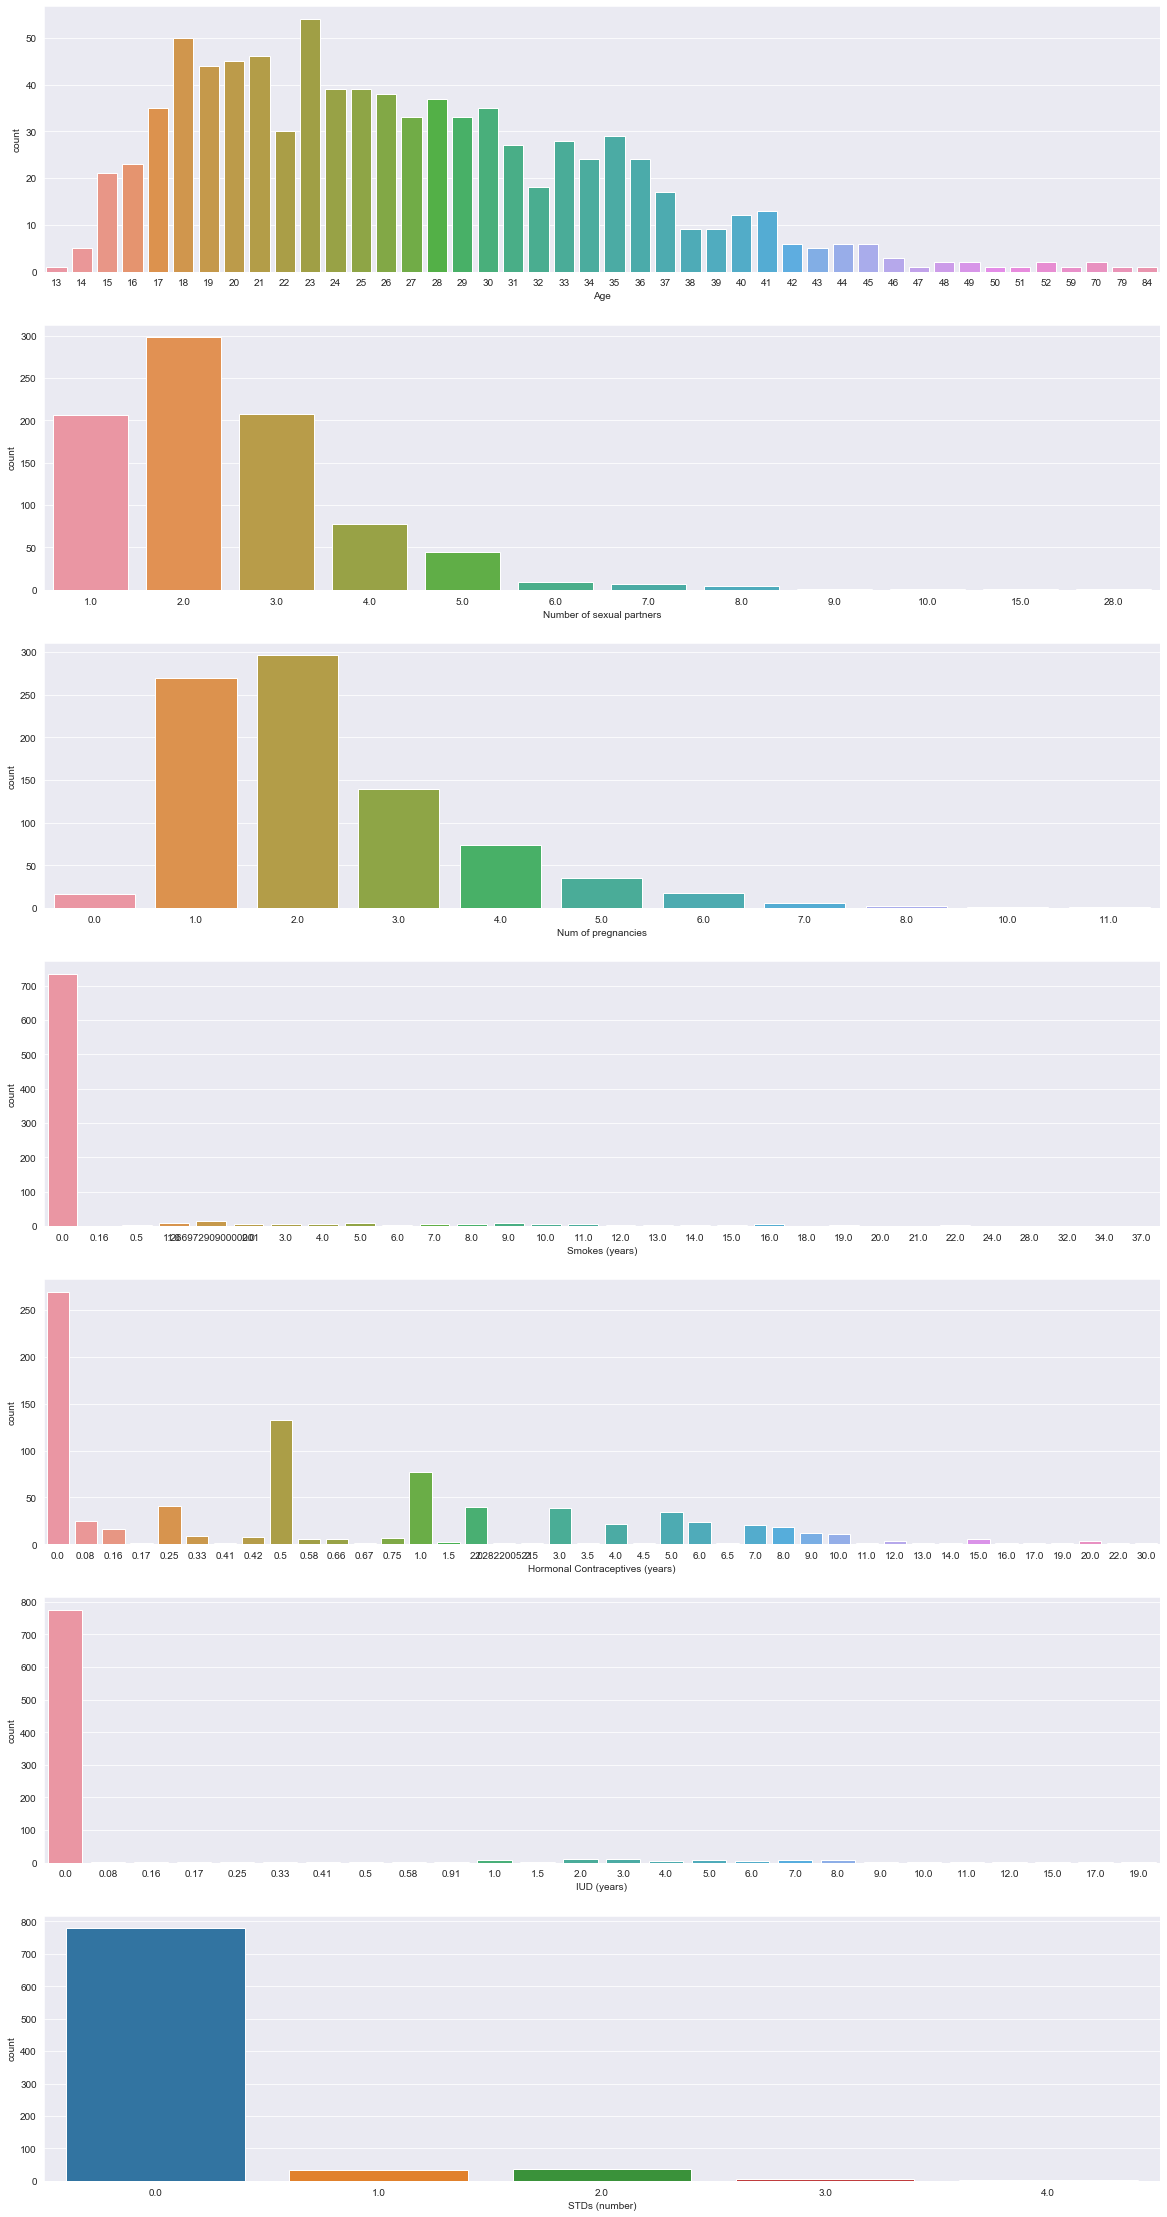

In [16]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(7,1,figsize=(20,40))
sns.countplot(x='Age', data=df, ax=ax1)
sns.countplot(x='Number of sexual partners', data=df, ax=ax2)
sns.countplot(x='Num of pregnancies', data=df, ax=ax3)
sns.countplot(x='Smokes (years)', data=df, ax=ax4)
sns.countplot(x='Hormonal Contraceptives (years)', data=df, ax=ax5)
sns.countplot(x='IUD (years)', data=df, ax=ax6)
sns.countplot(x='STDs (number)', data=df, ax=ax7)

### Shuffle the data, and split them into train set and test set.

In [17]:
#Shuffle
np.random.seed(42)
df_data_shuffle = df_data.iloc[np.random.permutation(len(df_data))]

df_train = df_data_shuffle.iloc[1:686, :]
df_test = df_data_shuffle.iloc[686: , :]

### Defining features and labels

In [18]:
#features/labels
df_train_feature = df_train[['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs (number)',
       'STDs:condylomatosis', 'STDs:cervical condylomatosis',
       'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
       'STDs:syphilis', 'STDs:pelvic inflammatory disease',
       'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS',
       'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis', 
       'Smokes_0.0', 'Smokes_1.0',
       'Hormonal Contraceptives_0.0', 'Hormonal Contraceptives_1.0', 'IUD_0.0',
       'IUD_1.0', 'STDs_0.0', 'STDs_1.0', 'Dx:Cancer_0', 'Dx:Cancer_1',
       'Dx:CIN_0', 'Dx:CIN_1', 'Dx:HPV_0', 'Dx:HPV_1', 'Dx_0', 'Dx_1',
       'Hinselmann_0', 'Hinselmann_1', 'Citology_0', 'Citology_1','Schiller_0','Schiller_1']]

train_label = np.array(df_train['Biopsy'])

df_test_feature = df_test[['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs (number)',
       'STDs:condylomatosis', 'STDs:cervical condylomatosis',
       'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
       'STDs:syphilis', 'STDs:pelvic inflammatory disease',
       'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS',
       'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis', 
       'Smokes_0.0', 'Smokes_1.0',
       'Hormonal Contraceptives_0.0', 'Hormonal Contraceptives_1.0', 'IUD_0.0',
       'IUD_1.0', 'STDs_0.0', 'STDs_1.0', 'Dx:Cancer_0', 'Dx:Cancer_1',
       'Dx:CIN_0', 'Dx:CIN_1', 'Dx:HPV_0', 'Dx:HPV_1', 'Dx_0', 'Dx_1',
       'Hinselmann_0', 'Hinselmann_1', 'Citology_0', 'Citology_1','Schiller_0','Schiller_1']]

test_label = np.array(df_test['Biopsy'])

### Data normalization

In [19]:
#Normalization
from sklearn import preprocessing
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
train_feature = minmax_scale.fit_transform(df_train_feature)
test_feature = minmax_scale.fit_transform(df_test_feature)

In [20]:
#Make sure if it's the shape what we want!
print(train_feature[0])
print(train_label[0])
print(test_feature[0])
print(test_label[0])

[0.14084507 0.07407407 0.31818182 0.18181818 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.14285714 0.0952381
 1.         0.         1.         0.         1.         0.
 1.         0.         1.         0.         1.         0.
 1.         0.         1.         0.         1.         0.
 1.         0.         1.         0.        ]
0
[0.61764706 0.33333333 0.25       0.42857143 0.28125    0.3375
 0.89473684 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.15       0.1
 0.         1.         0.         1.         1.         0.
 1.         0.         1.         0.         1.         0.
 1.         0.         1.         0.         1.         0.
 1.         0.         1.         0.        ]
0


In [21]:
train_feature.shape

(685, 46)

### 3.a  Model designing/training/visualization

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               23500     
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               100200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 123,901
Trainable params: 123,901
Non-trainable params: 0
________________________________________________________________

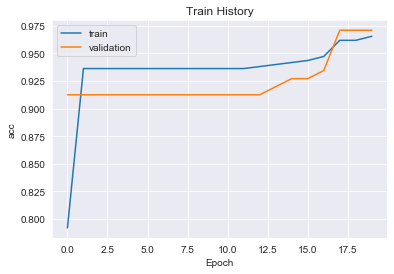

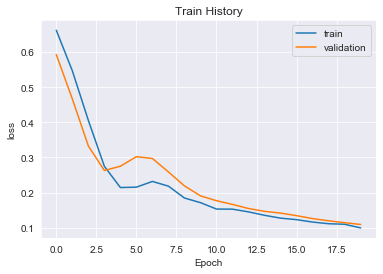

In [22]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()


########## Model designing ###########

model = Sequential() 

#Input layer
model.add(Dense(units=500, 
                input_dim=46, 
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))

#Hidden layer 1
model.add(Dense(units=200,  
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))

#Output layer
model.add(Dense(units=1,
                kernel_initializer='uniform', 
                activation='sigmoid'))

print(model.summary()) #for showing the structure and parameters

# Defining how to measure performance
model.compile(loss='binary_crossentropy',   
              optimizer='adam', metrics=['accuracy'])

# Train the model
# Verbose=2, showing loss and accuracy change timely
train_history = model.fit(x=train_feature, y=train_label,  
                          validation_split=0.2, epochs=20, 
                          batch_size=200, verbose=2) 

#visualize the loss and accuracy after each epoch
show_train_history(train_history,'acc','val_acc')
show_train_history(train_history,'loss','val_loss')

#For saving weights
#model.save_weights("./models/Cervical_Orig_MLP.h5")
#print('model saved to disk')

### 3.b Differentially private training

In [85]:
# Hyperparameters
l2_norm_clip=1.5
noise_multiplier=1.1
num_microbatches=1
learning_rate=0.00001
batch_size = 32
num_training_samples = 685
epochs = 20

In [83]:
def compute_epsilon(steps):
  """Computes epsilon value for given hyperparameters."""
  if noise_multiplier == 0.0:
    return float('inf')
  orders = [1 + x / 10. for x in range(1, 100)] + list(range(2, 32))
  sampling_probability = batch_size / num_training_samples
  rdp = compute_rdp(q=sampling_probability,
                    noise_multiplier=noise_multiplier,
                    steps=steps,
                    orders=orders)
  # Delta is set to 1e-3 because Cervical cancer has ~685 training points.
  print(get_privacy_spent(orders, rdp, target_delta=1e-3))
  return get_privacy_spent(orders, rdp, target_delta=1e-3)[0]

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 500)               23500     
_________________________________________________________________
dropout_14 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 200)               100200    
_________________________________________________________________
dropout_15 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 201       
Total params: 123,901
Trainable params: 123,901
Non-trainable params: 0
_________________________________________________________________
None
Train on 548 samples, validate on 137 samples
Epoch 1/20
548/548 - 1s - loss: 0.6984 - acc: 0.3029 - val_loss

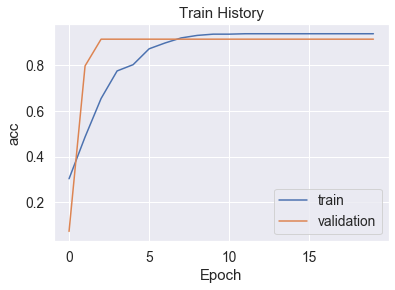

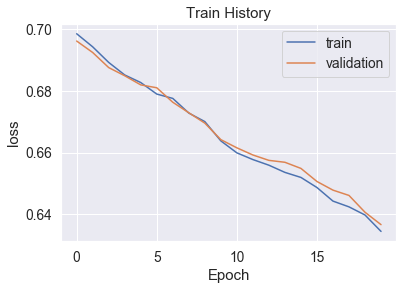

In [86]:
dp_model = Sequential() 

#Input layer
dp_model.add(Dense(units=500, 
                input_dim=46, 
                kernel_initializer='uniform', 
                activation='relu'))
dp_model.add(Dropout(0.5))

#Hidden layer 1
dp_model.add(Dense(units=200,  
                kernel_initializer='uniform', 
                activation='relu'))
dp_model.add(Dropout(0.5))

#Output layer
dp_model.add(Dense(units=1,
                kernel_initializer='uniform', 
                activation='sigmoid'))

print(dp_model.summary()) #for showing the structure and parameters

# Defining how to measure performance
'''
custom_sgd_optimizer = DPGradientDescentGaussianOptimizer(
                    l2_norm_clip=l2_norm_clip,
                    noise_multiplier=noise_multiplier,
                    num_microbatches=num_microbatches,
                    learning_rate=learning_rate)

'''
#dp_ave_query = GaussianAverageQuery(l2_norm_clip, l2_norm_clip * noise_multiplier, num_microbatches)
dp_sum_query = GaussianSumQuery(l2_norm_clip, l2_norm_clip * noise_multiplier)
custom_adam_optimizer = DPAdamOptimizer( 
                    num_microbatches=num_microbatches,
                    dp_sum_query=dp_sum_query)

dp_model.compile(loss='binary_crossentropy',   
              optimizer=custom_adam_optimizer, metrics=['accuracy'])

# Train the model
# Verbose=2, showing loss and accuracy change timely
train_history_dp = dp_model.fit(x=train_feature, y=train_label,  
                          validation_split=0.2, epochs=epochs, 
                          batch_size=batch_size, verbose=2) 

#visualize the loss and accuracy after each epoch
show_train_history(train_history_dp,'acc','val_acc')
show_train_history(train_history_dp,'loss','val_loss')

#For saving weights
#model.save_weights("./models/Cervical_Dp_MLP.h5")
#print('model saved to disk')

### 4.a Original model prediction accuracy

In [59]:
scores = model.evaluate(test_feature, test_label)
print('\n')
print('accuracy=',scores[1])

172/172 [==============================] - 0s 73us/sample - loss: 0.0910 - acc: 0.9477


accuracy= 0.9476744


In [60]:
# Answer sheet
prediction = model.predict_classes(test_feature)

In [61]:
# Create a dataframe for prediction and correct answer
df_ans = pd.DataFrame({'Biopsy' :test_label})
df_ans['Prediction'] = prediction

In [62]:
df_ans

,Biopsy,Prediction
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
167,0,0
168,0,0
169,0,0
170,0,0


List rows with wrong predictions

In [63]:
df_ans[ df_ans['Biopsy'] != df_ans['Prediction'] ]

,Biopsy,Prediction
48,1,0
65,1,0
80,0,1
111,1,0
121,0,1
128,1,0
135,0,1
145,0,1
146,0,1


In [64]:
df_ans['Prediction'].value_counts()

0    163
1      9
Name: Prediction, dtype: int64

In [65]:
df_ans['Biopsy'].value_counts()

0    164
1      8
Name: Biopsy, dtype: int64

### 4.b Differentially private model prediction accuracy

In [87]:
scores = dp_model.evaluate(test_feature, test_label)
print('\n')
print('accuracy=',scores[1])

172/172 [==============================] - 0s 69us/sample - loss: 0.6308 - acc: 0.9535


accuracy= 0.95348835


In [67]:
prediction = dp_model.predict_classes(test_feature)

In [68]:
# Create a dataframe for prediction and correct answer
df_ans_dp = pd.DataFrame({'Biopsy_dp' :test_label})
df_ans_dp['Prediction_dp'] = prediction

In [69]:
df_ans_dp

,Biopsy_dp,Prediction_dp
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
167,0,0
168,0,0
169,0,0
170,0,0


In [70]:
df_ans_dp['Prediction_dp'].value_counts()

0    172
Name: Prediction_dp, dtype: int64

In [71]:
df_ans_dp['Biopsy_dp'].value_counts()

0    164
1      8
Name: Biopsy_dp, dtype: int64

In [72]:
eps = compute_epsilon(epochs * num_training_samples // batch_size)
print('For delta=1e-3, the current epsilon is: %.2f' % eps)

(2.291028023707571, 0.001, 7.0)
For delta=1e-3, the current epsilon is: 2.29


### Confusion matrix

total test case number:  172


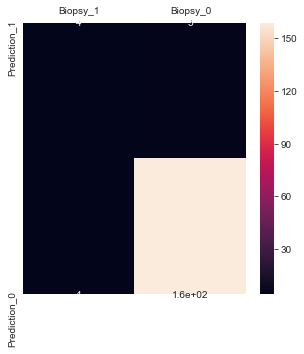

In [40]:
cols = ['Biopsy_1','Biopsy_0']  #Gold standard
rows = ['Prediction_1','Prediction_0'] #diagnostic tool (our prediction)

B1P1 = len(df_ans[(df_ans['Prediction'] == df_ans['Biopsy']) & (df_ans['Biopsy'] == 1)])
B1P0 = len(df_ans[(df_ans['Prediction'] != df_ans['Biopsy']) & (df_ans['Biopsy'] == 1)])
B0P1 = len(df_ans[(df_ans['Prediction'] != df_ans['Biopsy']) & (df_ans['Biopsy'] == 0)])
B0P0 = len(df_ans[(df_ans['Prediction'] == df_ans['Biopsy']) & (df_ans['Biopsy'] == 0)])

conf = np.array([[B1P1,B0P1],[B1P0,B0P0]])
df_cm = pd.DataFrame(conf, columns = [i for i in cols], index = [i for i in rows])

f, ax= plt.subplots(figsize = (5, 5))
sns.heatmap(df_cm, annot=True, ax=ax) 
ax.xaxis.set_ticks_position('top') #Making x label be on top is common in textbooks.

print('total test case number: ', np.sum(conf))

### Calculating sensitivity, specificity, false_positive_rate and false_negative_rate

In [41]:
def model_efficacy(conf):
    total_num = np.sum(conf)
    sen = conf[0][0]/(conf[0][0]+conf[1][0])
    spe = conf[1][1]/(conf[1][0]+conf[1][1])
    false_positive_rate = conf[0][1]/(conf[0][1]+conf[1][1])
    false_negative_rate = conf[1][0]/(conf[0][0]+conf[1][0])
    
    print('total_num: ',total_num)
    print('G1P1: ',conf[0][0]) #G = gold standard; P = prediction
    print('G0P1: ',conf[0][1])
    print('G1P0: ',conf[1][0])
    print('G0P0: ',conf[1][1])
    print('##########################')
    print('sensitivity: ',sen)
    print('specificity: ',spe)
    print('false_positive_rate: ',false_positive_rate)
    print('false_negative_rate: ',false_negative_rate)
    
    return total_num, sen, spe, false_positive_rate, false_negative_rate

model_efficacy(conf)
    

total_num:  172
G1P1:  4
G0P1:  5
G1P0:  4
G0P0:  159
##########################
sensitivity:  0.5
specificity:  0.9754601226993865
false_positive_rate:  0.03048780487804878
false_negative_rate:  0.5


(172, 0.5, 0.9754601226993865, 0.03048780487804878, 0.5)

### Appendix: Analysis with other categories of data

#### Age

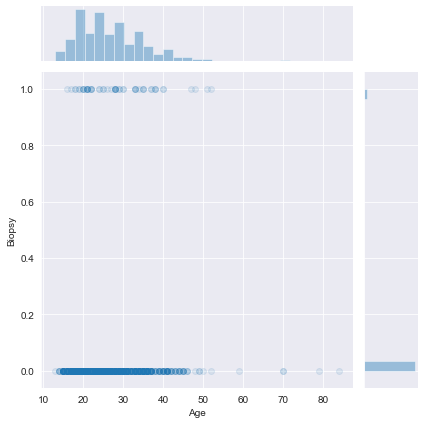

In [42]:
import seaborn as sns
sns.jointplot(x='Age', y='Biopsy', data=df, alpha=0.1) 
#By adding alpha, we can see the density of the scattered spots clearly.

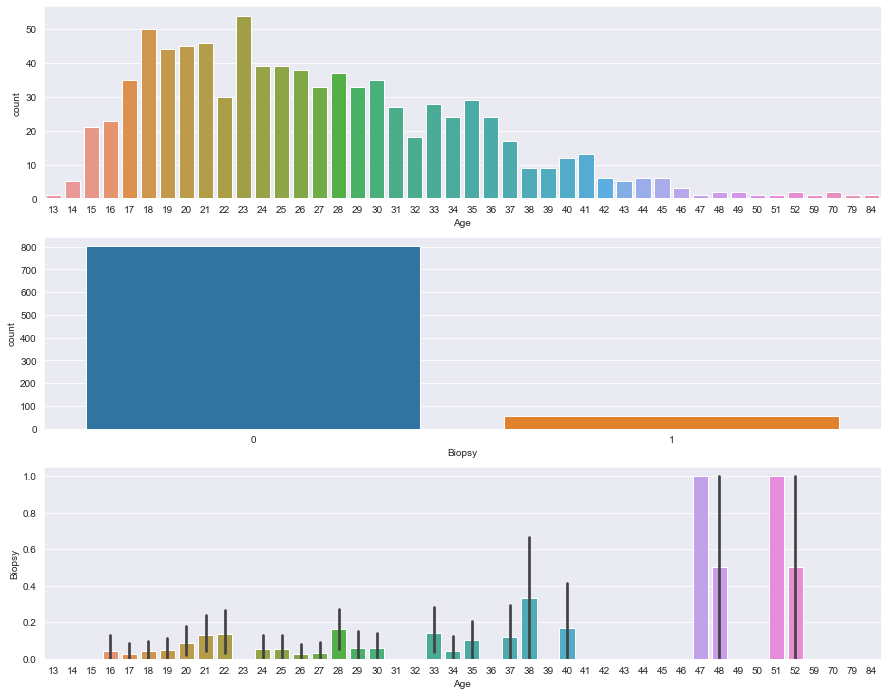

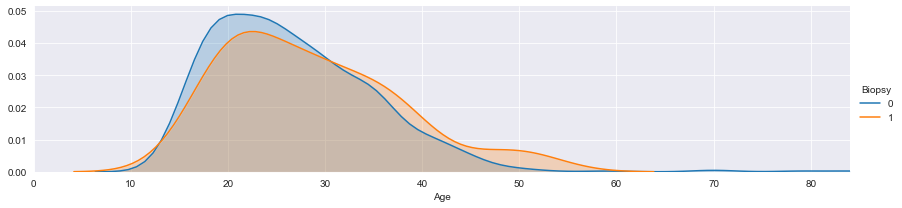

In [43]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,12))
sns.countplot(x='Age', data=df, ax=ax1)
sns.countplot(x='Biopsy', data=df, ax=ax2)
sns.barplot(x='Age', y='Biopsy', data=df, ax=ax3)

#Stratified
facet = sns.FacetGrid(df, hue='Biopsy',aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df['Age'].max()))
facet.add_legend()

#### Number of sexual partners

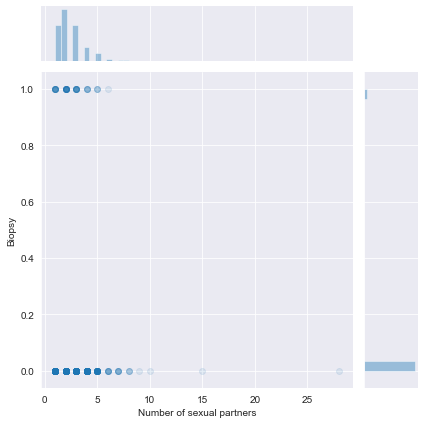

In [44]:
import seaborn as sns
sns.jointplot(x='Number of sexual partners', y='Biopsy', data=df, alpha=0.1) 
#By adding alpha, we can see the density of the scattered spots clearly.

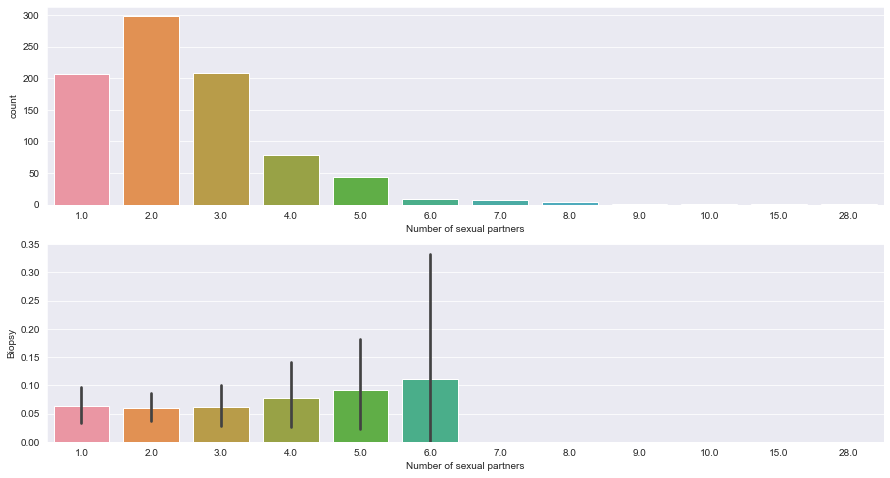

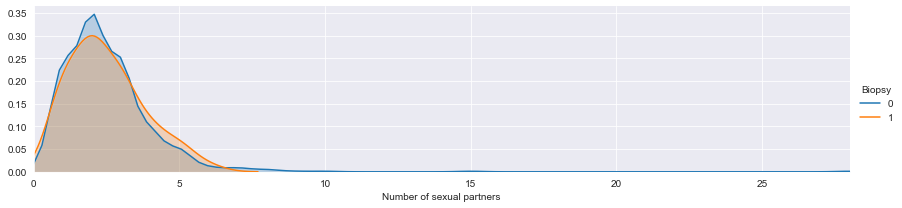

In [45]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,8))
sns.countplot(x='Number of sexual partners', data=df, ax=ax1)
sns.barplot(x='Number of sexual partners', y='Biopsy', data=df, ax=ax2) #categorical to categorical

#continuous to categorical
facet = sns.FacetGrid(df, hue='Biopsy',aspect=4)
facet.map(sns.kdeplot,'Number of sexual partners',shade= True)
facet.set(xlim=(0, df['Number of sexual partners'].max()))
facet.add_legend()

#### Num of pregnancies

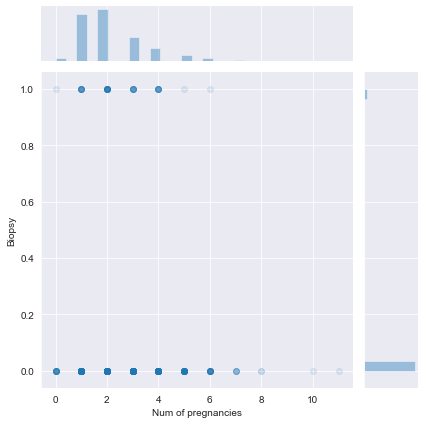

In [46]:
import seaborn as sns
sns.jointplot(x='Num of pregnancies', y='Biopsy', data=df, alpha=0.1) 

/Users/Srivatsa/Desktop/Tutorials & Notes/Y4S1/ISM/code/venv/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/Srivatsa/Desktop/Tutorials & Notes/Y4S1/ISM/code/venv/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


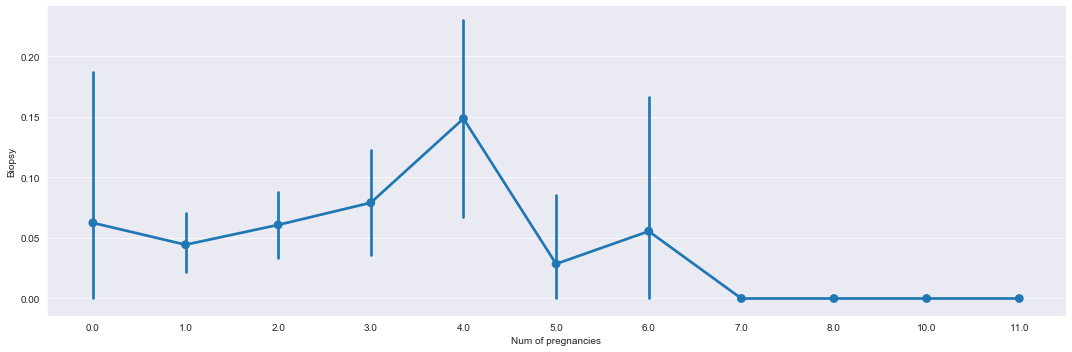

In [47]:
sns.factorplot('Num of pregnancies','Biopsy',data=df, size=5, aspect=3)

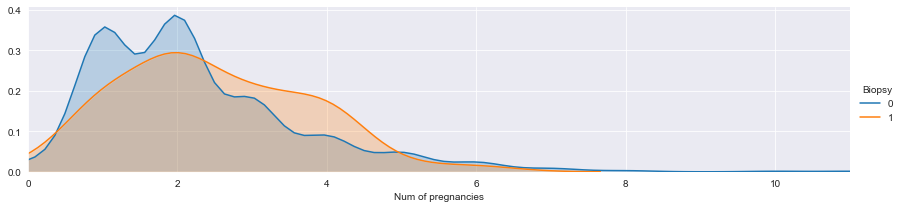

In [48]:
#continuous to categorical
facet = sns.FacetGrid(df, hue='Biopsy',aspect=4)
facet.map(sns.kdeplot,'Num of pregnancies',shade= True)
facet.set(xlim=(0, df['Num of pregnancies'].max()))
facet.add_legend()

#### Cytology

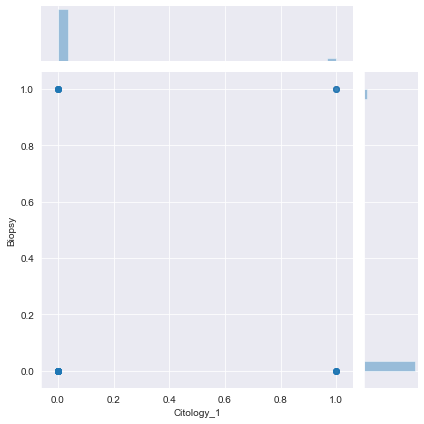

In [49]:
import seaborn as sns
sns.jointplot(x='Citology_1', y='Biopsy', data=df, alpha=0.1) 
# Hard do see anything...

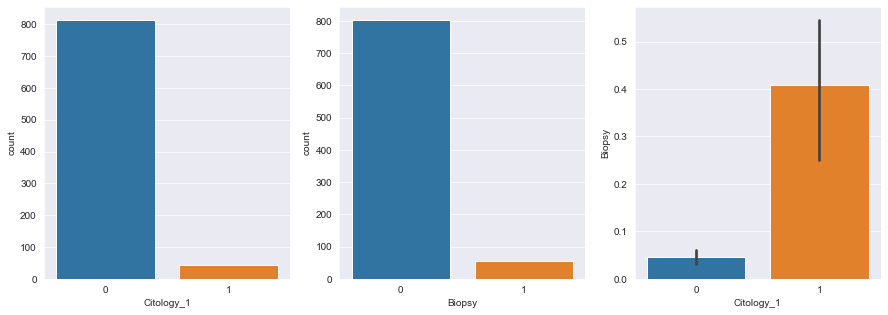

In [50]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
sns.countplot(x='Citology_1', data=df, ax=axis1)
sns.countplot(x='Biopsy', data=df, ax=axis2)
sns.barplot(x='Citology_1', y='Biopsy', data=df, ax=axis3)  #categorical to categorical

#### Schiller

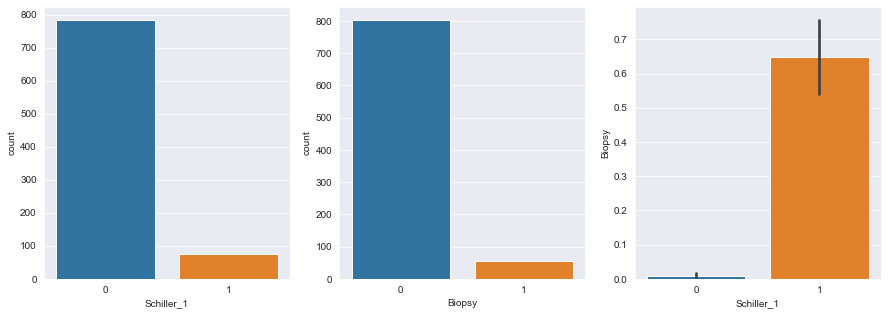

In [51]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
sns.countplot(x='Schiller_1', data=df, ax=axis1)
sns.countplot(x='Biopsy', data=df, ax=axis2)
sns.barplot(x='Schiller_1', y='Biopsy', data=df, ax=axis3) #categorical to categorical

### Correlation between all elements (df) 

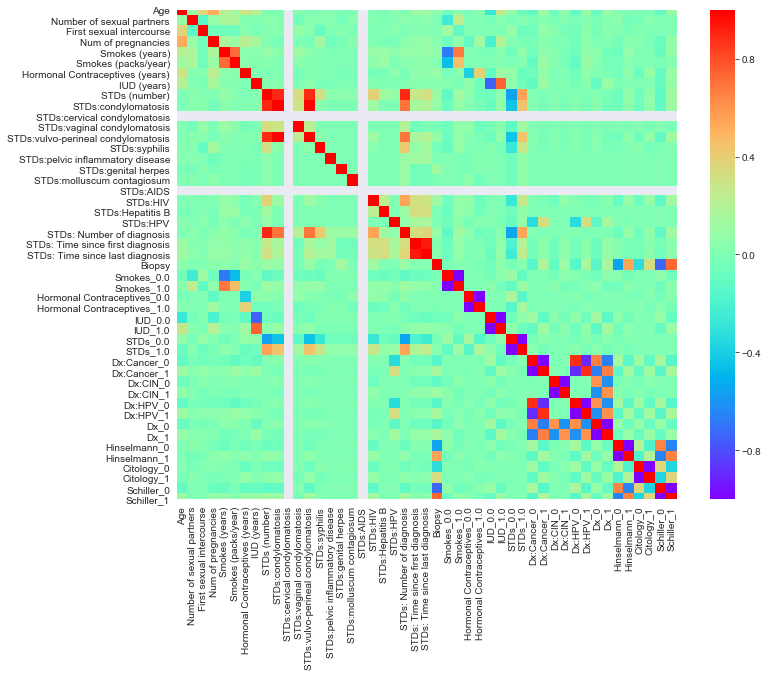

In [52]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True, cmap='rainbow')

In [53]:
df['STDs:cervical condylomatosis'].value_counts()

0.0    858
Name: STDs:cervical condylomatosis, dtype: int64

In [54]:
df['STDs:AIDS'].value_counts()

0.0    858
Name: STDs:AIDS, dtype: int64

### List the heatmap of top correlation

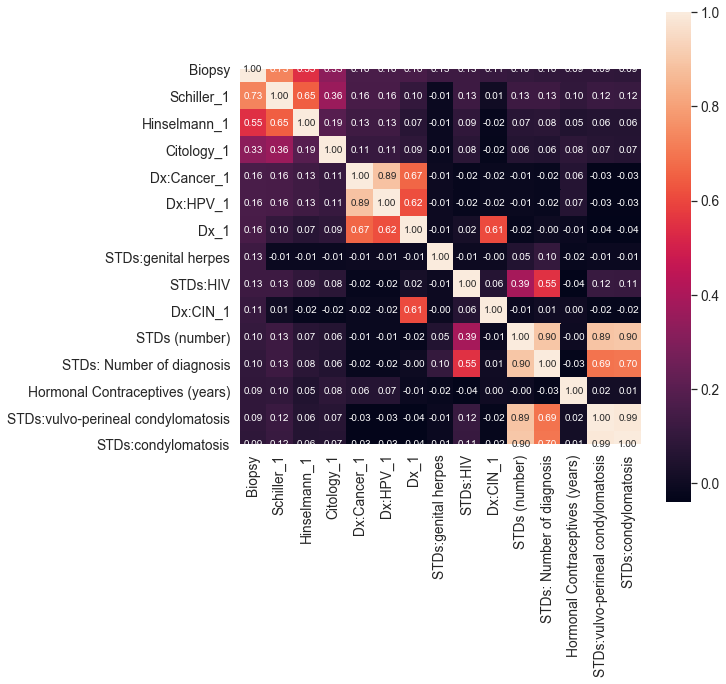

In [55]:
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Biopsy')['Biopsy'].index
cm = np.corrcoef(df[cols].values.T)

plt.figure(figsize=(9,9))

sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels = cols.values, xticklabels = cols.values)
plt.show()